# MTI under homo assumption

In [1]:
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.mtsolvers.homo_mti import collect_source_angles, pwave_zcomp_Greens
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict
from pyfrac.visualisation.traceviz import traceimage

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [3]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

# Initialisation

### Modelling Params

In [4]:
nr = 210
dt = 1e-3

dx = dy = dz = 10.
nx, nz, ny = [170, 150, 174]
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

vp = 4370
vel = vp * np.ones([nx, ny, nz])

### Load Data and src/rec locs

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Seismic Recording'}, xlabel='Receiver #', ylabel='Time'>)

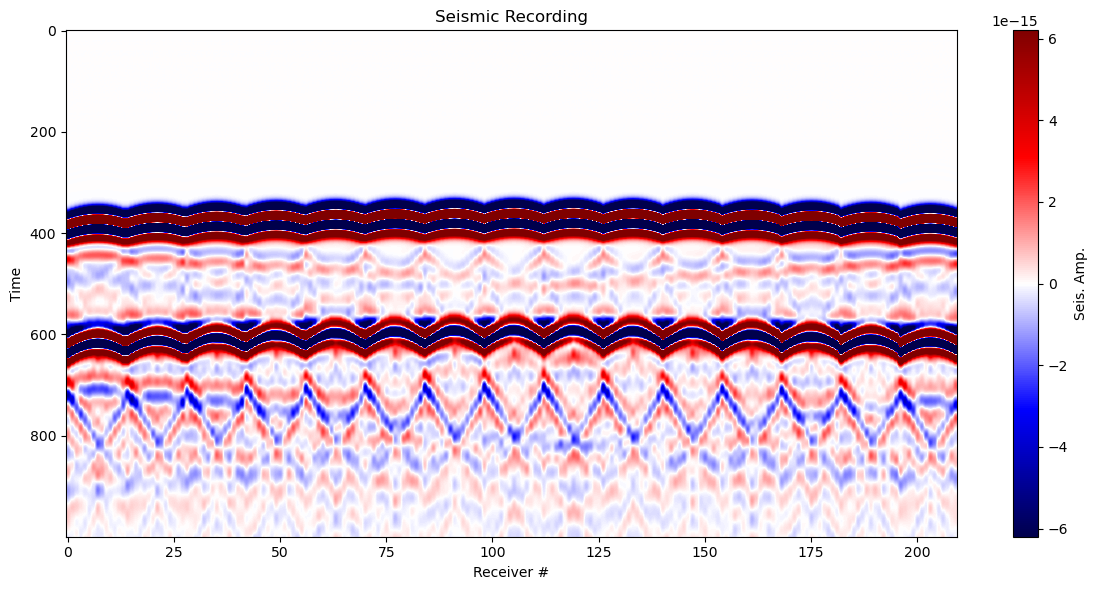

In [5]:
seispath = '/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/UTAH_Homo_tst/outputs/su'
expname = 'UTAH_Homo_tst'
vz = read_seis(os.path.join(seispath,'%s_vy.txt'%expname), nr)  # y=z in SOFI
traceimage(vz)

In [6]:
recs = np.loadtxt('/home/birniece/Documents/data/UTAH_FORGE/ClairesVMods/homo/receiver.dat').T
recs = np.array([recs[0],recs[2], recs[1]])

In [7]:
src = np.loadtxt('/home/birniece/Documents/data/UTAH_FORGE/ClairesVMods/homo/sources.dat').T
src_loc = np.array([src[0],src[2], src[1]])
src_freq = src[4]

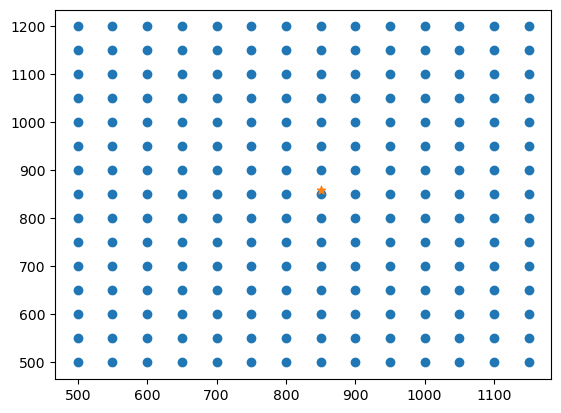

In [8]:
plt.scatter(recs[0],recs[1])
plt.scatter(src_loc[0],src_loc[1], marker='*')

## Get all necessary components

In [ ]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs, 
                                   srcs=recs[:,:1], 
                                   vel=vel, 
                                   mode='eikonal')[1]

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

In [ ]:
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [ ]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for specific source (location and frequency)

In [ ]:
omega_p = src_freq  # Assume central frequency of 25Hz
sloc_ind = [int(src_loc[0]//dx), int(src_loc[1]//dy), int(src_loc[2]//dz)]  # As indices of velocity model

In [ ]:
G_z = pwave_zcomp_Greens(gamma_sourceangles,
                       dist_table,
                       sloc_ind,
                       omega_p,
                       vel,
                       MT_comp_dict)

## Select P-wave amplitudes

In [ ]:
vz_shft = vz.copy() # Accounting for ignition time
sofi_shift = 50
source_times = sofi_shift+np.round(TTT_full[:,int(sx//dx),int(sy//dy),int(sz//dz)]/dt).astype(int)

vz_amps = np.ones(nr)
for i in range(nr):
    vz_amps[i] = vz_shft[i,source_times[i]]

In [ ]:
plt.imshow(vz_shft[:,np.min(source_times)-50:150+np.min(source_times)].T, aspect='auto',
           extent=[0, nr, 150+np.min(source_times), np.min(source_times)-50],
           cmap='RdBu',
          )
plt.scatter(range(nr),source_times, marker='o', facecolors='none', edgecolors='k', s=5)

# Running MTI

In [ ]:
u_zp_FD = vz_amps
MT_ls_FD, _, _, _  = lstsq(G_z.T, u_zp_FD)

In [ ]:
MT_BB_FD = MT_ls_FD.copy()
MT_BB_FD[0], MT_BB_FD[2] = MT_BB_FD[2], MT_BB_FD[0]
MT_BB_FD[5] = MT_BB_FD[3]
MT_BB_FD[3] = MT_BB_FD[4]
beachball(MT_BB_FD, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')